# IMPORT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from scipy.stats import randint

# DATA WRANGLING

## Data Gathering

In [2]:
# load dataset
file_path = './data/retail_store_inventory.csv'
dataset = pd.read_csv(file_path)

dataset.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


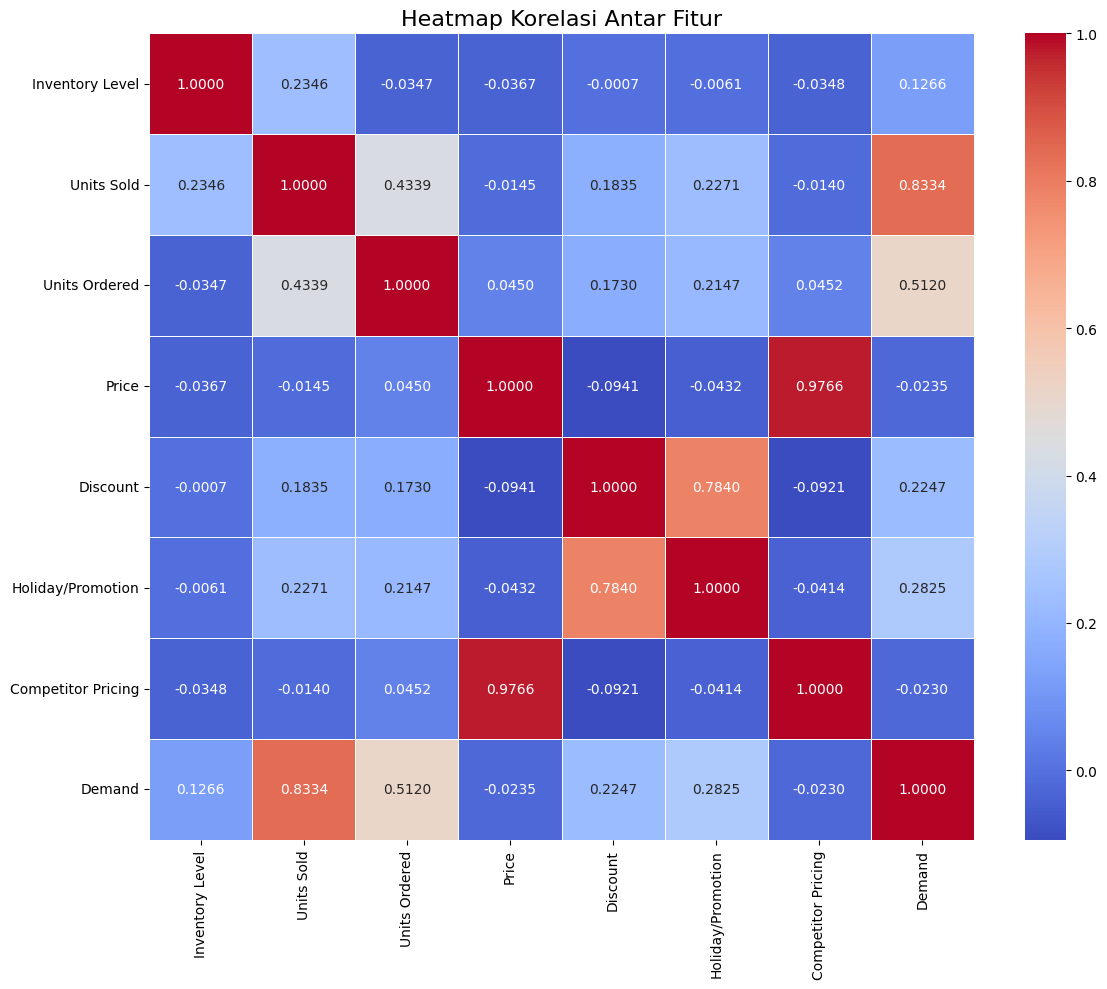

In [4]:
correlation_matrix = dataset.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)

plt.title("Heatmap Korelasi Antar Fitur", fontsize=16)
plt.tight_layout()
plt.show()

## Accessing data

In [3]:
# melihat ukuran data dan informasi dataset
print("\nShape of dataset:", dataset.shape, "\n")
dataset.info()


Shape of dataset: (73100, 15) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand              73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64

insight:
- terlihat dataset bersih tanpa ada missing value
- tipe data fitur date berupa object, bukan datetime

In [4]:
# melihat missing value
dataset.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand                0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

insight:
- dataset bersih tanpa missing value

In [5]:
# melihat duplikasi data dan ringkasan parameter statistik

print("Jumlah duplikasi data: ", dataset.duplicated().sum())
dataset.describe()

Jumlah duplikasi data:  0


,Inventory Level,Units Sold,Units Ordered,Demand,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


insight:
- di sini terlihat unit sold memiliki nilai 0
- selanjutnya akan dilihat seberapa banyak nilai 0 pada unit sold
- terlihat juga keanehan pada nilai min fitur demand, yang mana seharusnya tidak ada demand negatif

In [6]:
# Filter data dengan Units Sold <= 0
data_zero_units = dataset[dataset['Units Sold'] <= 0]

# Kelompokkan berdasarkan kategori dan hitung jumlahnya
kategori_dengan_units_0 = data_zero_units['Category'].value_counts()

# Tampilkan hasil
print(kategori_dengan_units_0)

Category
Clothing       75
Electronics    74
Furniture      72
Toys           70
Groceries      69
Name: count, dtype: int64


insight:
- terlihat cukup banyak nilai 0 pada unit sold di berbagai kategori produk
- akan kita buang baris data yang memiliki unit sold 0, karena akan mempengaruhi kinerja model

In [7]:
# Filter data Demand <= 0
data_zero_demand = dataset[dataset['Demand'] <= 0]

# Kelompokkan berdasarkan kategori dan hitung jumlahnya
kategori_dengan_demand_0 = data_zero_demand['Category'].value_counts()

# Tampilkan hasil
print(kategori_dengan_demand_0)

Category
Groceries      143
Toys           140
Clothing       132
Electronics    129
Furniture      129
Name: count, dtype: int64


insight:
- lumayan banyak jumlah nilai 0 per kategori nya pada fitur demand ini, lebih banyak dari fitur units sold
- akan saya buang baris data demand 0, karena akan mempengaruhi kinerja model

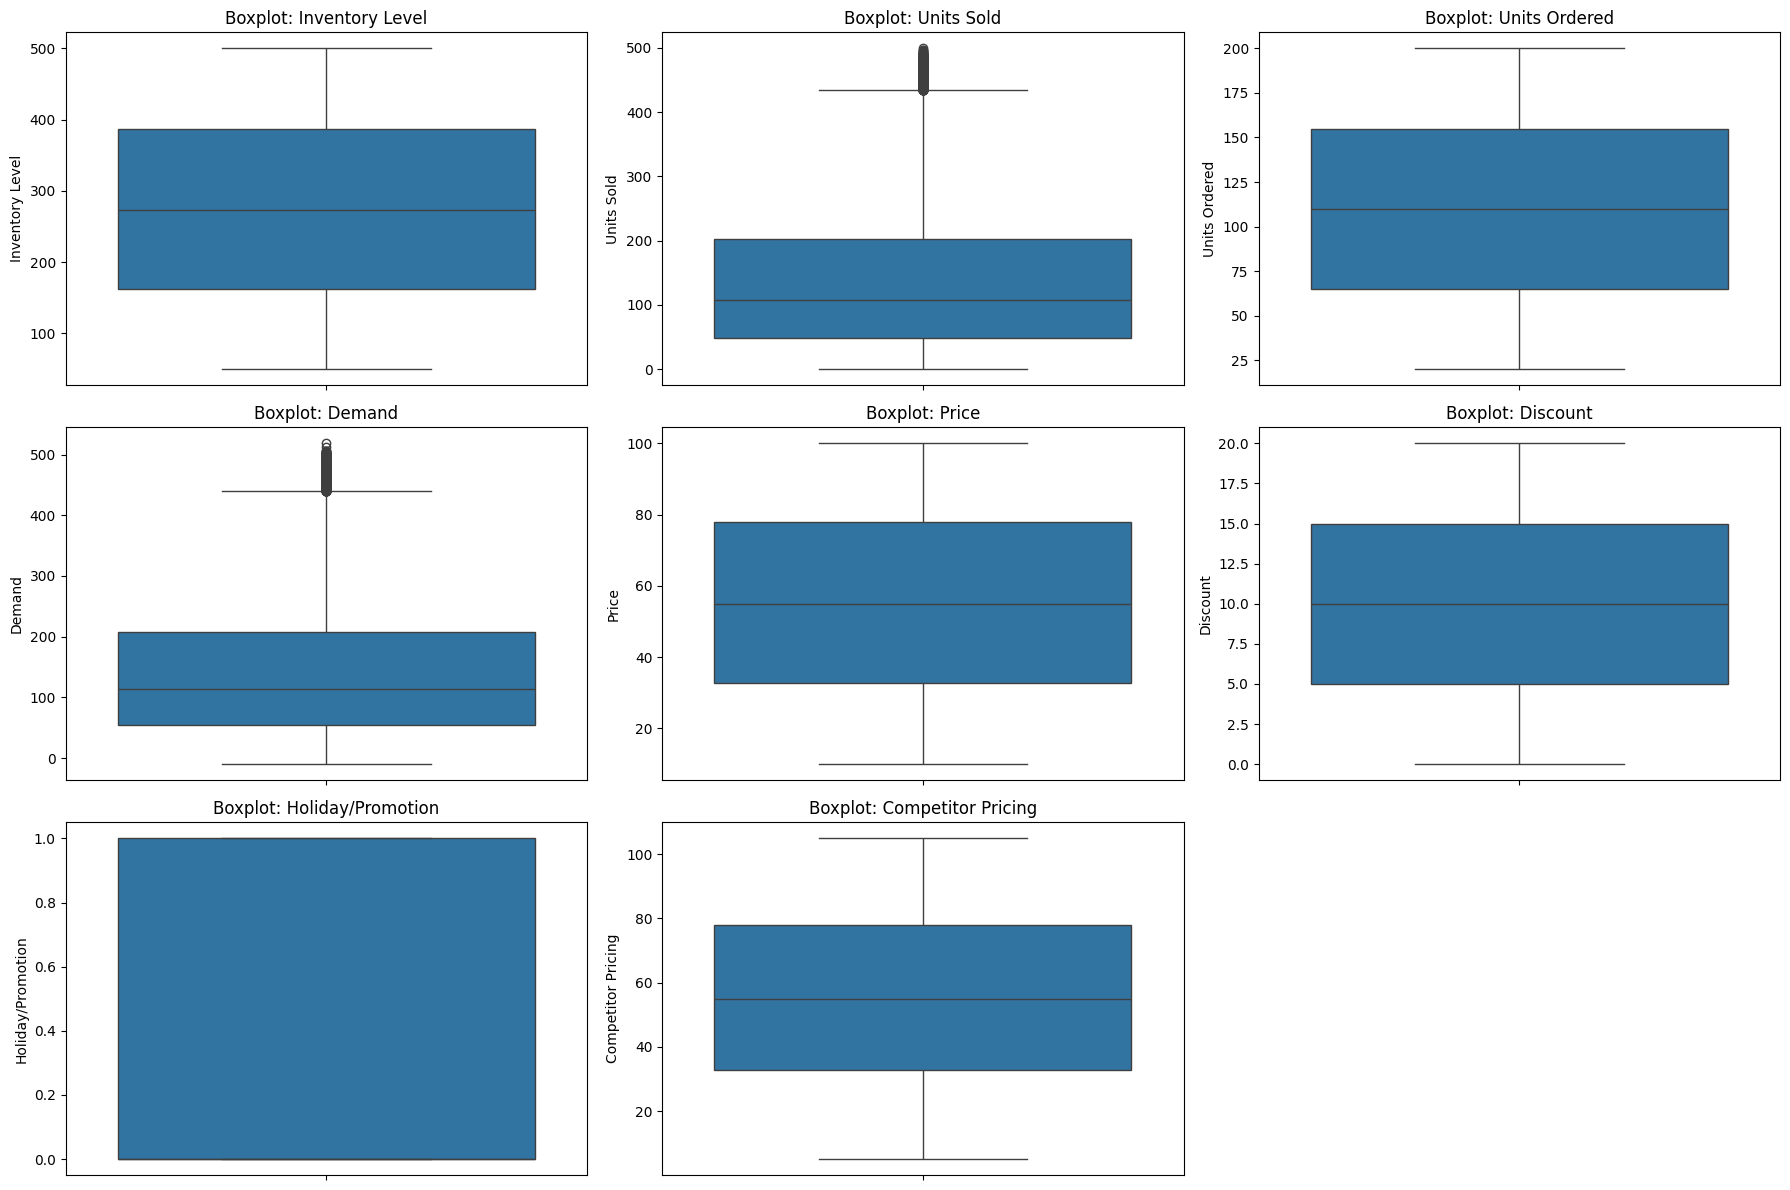

In [8]:
# boxplot untuk melihat outlier

numeric_cols = dataset.select_dtypes(include='number').columns # mengambil semua kolom numerik

# mengatur ukuran canvas sesuai jumlah kolom
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceiling division

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

# membuat boxplot untuk setiap kolom numerik
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=dataset[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.show()

insight:
- terlihat ada outlier pada fitur unit sold yang akan menjadi target prediksi, kemudian juga ada outlier pada fitur demand
- selanjutnya akan kita handle outlier pada data cleaning

## Cleaning Data

In [3]:
# mengubah tipe data pada kolom date menjadi datetime format
dataset['Date'] = pd.to_datetime(dataset['Date'])

# cek kembali info dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                73100 non-null  datetime64[ns]
 1   Store ID            73100 non-null  object        
 2   Product ID          73100 non-null  object        
 3   Category            73100 non-null  object        
 4   Region              73100 non-null  object        
 5   Inventory Level     73100 non-null  int64         
 6   Units Sold          73100 non-null  int64         
 7   Units Ordered       73100 non-null  int64         
 8   Demand              73100 non-null  float64       
 9   Price               73100 non-null  float64       
 10  Discount            73100 non-null  int64         
 11  Weather Condition   73100 non-null  object        
 12  Holiday/Promotion   73100 non-null  int64         
 13  Competitor Pricing  73100 non-null  float64   

In [4]:
# menghapus baris dengan Unit Sold <= 0
df = dataset.copy() # menyalin dataset asli agar tidak merusak data mentah
print("\nJumlah baris sebelum filter Unit Sold & Demand < 0:", df.shape)
df = df[(df["Units Sold"] >=1) & (df["Demand"] >= 1)]
print("Jumlah baris setelah filter Unit Sold & Demand < 0:", df.shape)


Jumlah baris sebelum filter Unit Sold & Demand < 0: (73100, 15)
Jumlah baris setelah filter Unit Sold & Demand < 0: (72054, 15)


In [5]:
# handling outlier dengan metode IQR

print("Shape sebelum menghapus outlier:", df.shape)

# Pilih kolom
numeric_cols = ['Units Sold', 'Demand']

# Loop untuk setiap kolom numerik
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out outliers
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Shape setelah menghapus outlier:", df.shape)


Shape sebelum menghapus outlier: (72054, 15)
Shape setelah menghapus outlier: (71117, 15)


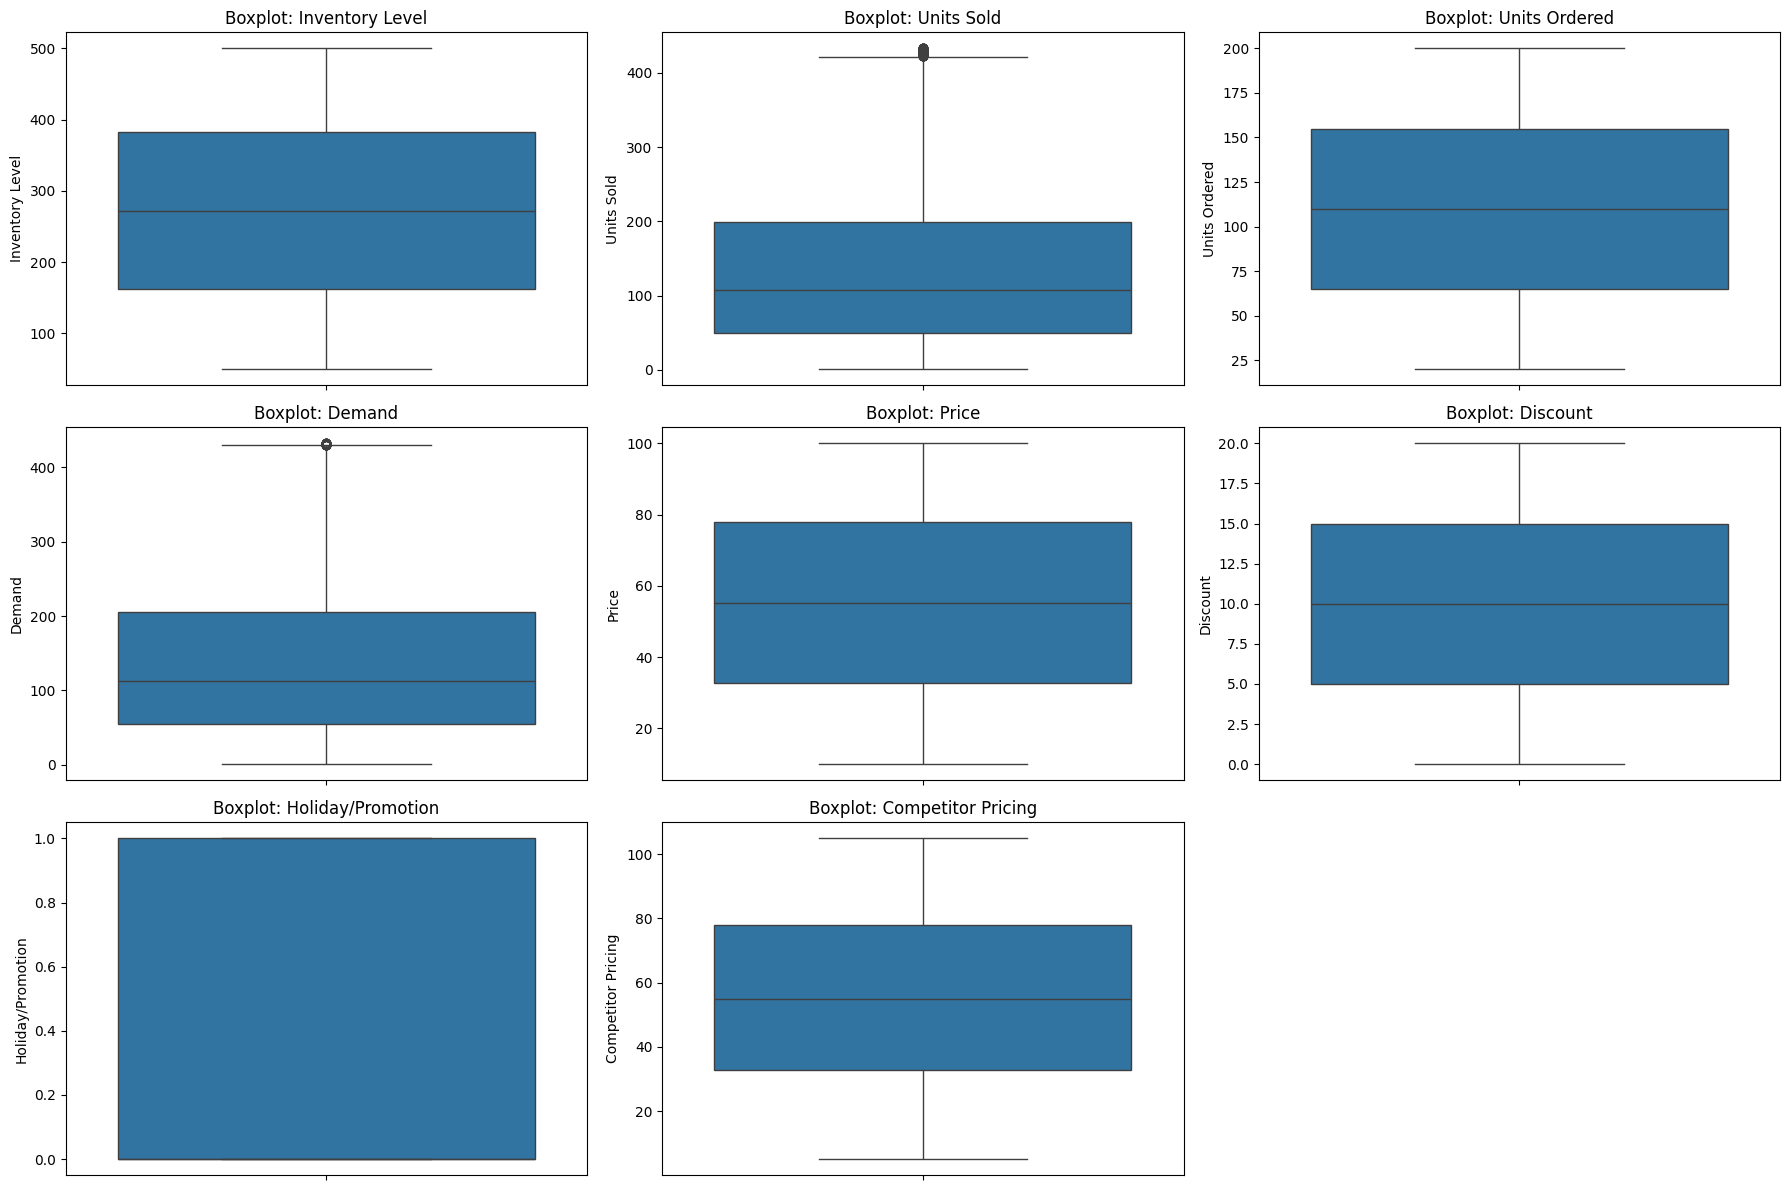

In [6]:
# cek kembali boxplotnya

numeric_cols = df.select_dtypes(include='number').columns # mengambil semua kolom numerik

# mengatur ukuran canvas sesuai jumlah kolom
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # ceiling division

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

# membuat boxplot untuk setiap kolom numerik
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

plt.show()

In [7]:
# Dataset asli dan dataset hasil cleaning
original_rows = dataset.shape[0]
cleaned_rows = df.shape[0]

# Hitung selisih dan persentase
removed_rows = original_rows - cleaned_rows
percent_removed = (removed_rows / original_rows) * 100

# Cetak hasil
print(f"Jumlah data awal      : {original_rows}")
print(f"Jumlah data bersih    : {cleaned_rows}")
print(f"Jumlah data dihapus   : {removed_rows}")
print(f"Persentase dihapus    : {percent_removed:.2f}%")

Jumlah data awal      : 73100
Jumlah data bersih    : 71117
Jumlah data dihapus   : 1983
Persentase dihapus    : 2.71%


In [8]:
# cek kembali ringkasan parameter statistiknya
df.describe()

,Date,Inventory Level,Units Sold,Units Ordered,Demand,Price,Discount,Holiday/Promotion,Competitor Pricing
count,71117,71117.000000,71117.000000,71117.000000,71117.000000,71117.000000,71117.000000,71117.000000,71117.000000
mean,2022-12-31 23:06:08.367619328,272.861201,134.307732,110.009562,139.429775,55.143561,10.006609,0.497884,55.156945
min,2022-01-01 00:00:00,50.000000,1.000000,20.000000,1.000000,10.000000,0.000000,0.000000,5.030000
25%,2022-07-02 00:00:00,162.000000,50.000000,65.000000,55.120000,32.630000,5.000000,0.000000,32.660000
50%,2023-01-01 00:00:00,272.000000,108.000000,110.000000,113.210000,55.080000,10.000000,0.000000,55.030000
75%,2023-07-03 00:00:00,383.000000,199.000000,155.000000,205.080000,77.880000,15.000000,1.000000,77.860000
max,2024-01-01 00:00:00,500.000000,433.000000,200.000000,432.100000,100.000000,20.000000,1.000000,104.940000
std,NaN,128.476299,103.100663,52.274887,103.250677,26.027006,7.084326,0.499999,26.199647


insight:
- terlihat ringkasan parameter statistik sudah cukup normal

# PREPROCESSING

In [9]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [ ]:
# membuat fitur baru

# menambahkan kolom DayofWeek untuk menganalisis tren mingguan serta bulan dan tahun untuk menangkap pola musiman
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month # 1 sampai 12
df['Day'] = df['Date'].dt.day # tanggal
df['DayOfWeek'] = df['Date'].dt.weekday # 0=senin ~ 6=minggu

# melihat dataset dengan kolom baru
print("Shape: ", df.shape)
print("dataset dengan feature baru:")
pd.set_option('display.max_columns', None)
df.head()

Shape:  (71117, 19)
dataset dengan feature baru:


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,Year,Month,Day,DayOfWeek
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn,2022,1,1,5
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn,2022,1,1,5
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer,2022,1,1,5
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn,2022,1,1,5
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer,2022,1,1,5


In [11]:
# Label Encoding kolom 'Seasonality'

print("Kategori Seasonality sebelum encoding:", df['Seasonality'].unique())

label_encoder = LabelEncoder()
df['Seasonality'] = label_encoder.fit_transform(df['Seasonality'])

# Periksa hasil encoding
print("Seasonality Setelah encoding:", df['Seasonality'].unique())

Kategori Seasonality sebelum encoding: ['Autumn' 'Summer' 'Winter' 'Spring']
Seasonality Setelah encoding: [0 2 3 1]


In [12]:
print("nama kategory sebelum encoding:", df['Category'].unique())
# Pilih fitur kategorikal yang relevan
categorical_cols = ["Category"]

# One-hot encoding pada kolom Country
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)


nama kategory sebelum encoding: ['Groceries' 'Toys' 'Electronics' 'Furniture' 'Clothing']


In [13]:
print("Kolom yang tersedia setelah preprocessing:")
print(df.columns)

print("\nDataFrame shape setelah preprocessing:", df.shape)

Kolom yang tersedia setelah preprocessing:
Index(['Date', 'Store ID', 'Product ID', 'Region', 'Inventory Level',
       'Units Sold', 'Units Ordered', 'Demand', 'Price', 'Discount',
       'Weather Condition', 'Holiday/Promotion', 'Competitor Pricing',
       'Seasonality', 'Year', 'Month', 'Day', 'DayOfWeek', 'Category_Clothing',
       'Category_Electronics', 'Category_Furniture', 'Category_Groceries',
       'Category_Toys'],
      dtype='object')

DataFrame shape setelah preprocessing: (71117, 23)


In [14]:
df.head()

,Date,Store ID,Product ID,Region,Inventory Level,Units Sold,Units Ordered,Demand,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,Year,Month,Day,DayOfWeek,Category_Clothing,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys
0,2022-01-01,S001,P0001,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,0,2022,1,1,5,False,False,False,True,False
1,2022-01-01,S001,P0002,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,0,2022,1,1,5,False,False,False,False,True
2,2022-01-01,S001,P0003,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,2,2022,1,1,5,False,False,False,False,True
3,2022-01-01,S001,P0004,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,0,2022,1,1,5,False,False,False,False,True
4,2022-01-01,S001,P0005,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,2,2022,1,1,5,False,True,False,False,False


In [ ]:
# Data splitting

# Memilih fitur input dan target untuk model
features = ['Inventory Level', 'Demand', 'Price', 'Discount', 'Competitor Pricing', 'Seasonality', 'Month', 'Category_Clothing', 'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys']
target = 'Units Sold'

# Membagi dataset menjadi data latih dan data uji (data splitting)
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training Data:", X_train.shape)
print("Shape of Testing Data:", X_test.shape)

Shape of Training Data: (56893, 12)
Shape of Testing Data: (14224, 12)


In [16]:
# Menghitung panjang/jumlah data
print("Jumlah data: ", len(X))
# Menghitung panjang/jumlah data pada X_train
print("Jumlah data latih: ", len(X_train))
# Menghitung panjang/jumlah data pada X_test
print("Jumlah data test: ", len(X_test))

Jumlah data:  71117
Jumlah data latih:  56893
Jumlah data test:  14224


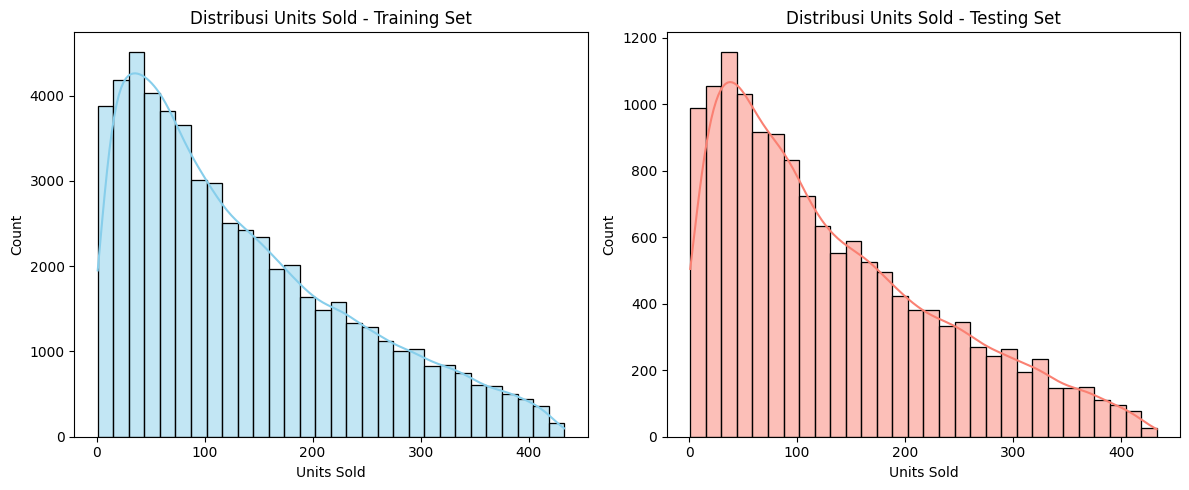

In [17]:
# cek plot distribusi unit sold

plt.figure(figsize=(12, 5))

# Distribusi pada training set
plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=30, kde=True, color='skyblue')
plt.title('Distribusi Units Sold - Training Set')
plt.xlabel('Units Sold')

# Distribusi pada testing set
plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=30, kde=True, color='salmon')
plt.title('Distribusi Units Sold - Testing Set')
plt.xlabel('Units Sold')

plt.tight_layout()
plt.show()

# MODEL DEVELOPMENT & TESTING

## Baseline Model

In [52]:
# Membuat model Random Forest
rf = RandomForestRegressor(random_state=42)

# melatih model
rf.fit(X_train, y_train)

# Prediksi
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# 5. Evaluasi
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0 # Filter untuk mengabaikan nilai nol
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"Train MAE: {mae_train:.2f}")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train MAPE: {mape_train:.2f}%")
print("-" * 40)
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAPE: {mape_test:.2f}%")

Train MAE: 2.72
Train RMSE: 3.24
Train MAPE: 7.23%
----------------------------------------
Test MAE: 7.37
Test RMSE: 8.68
Test MAPE: 19.93%


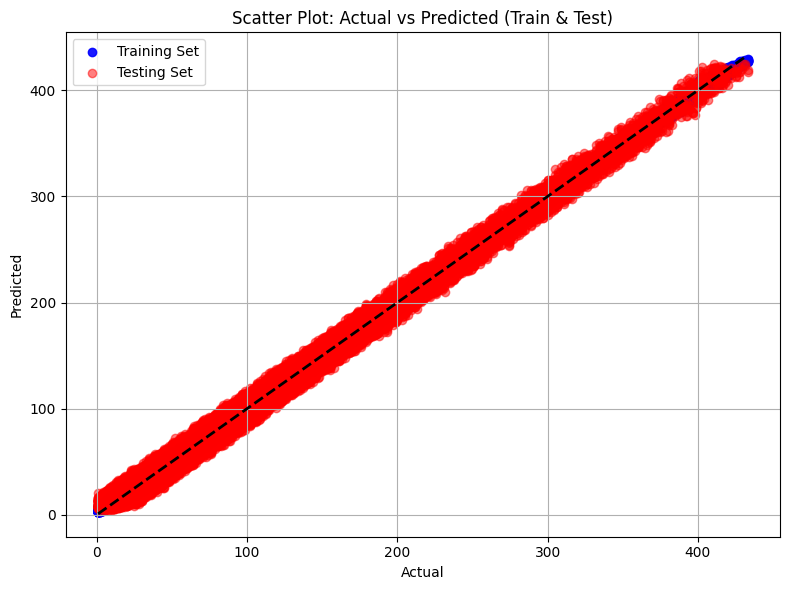

In [45]:
# plot data y aktual vs y hasil prediksi

# Scatter plot
plt.figure(figsize=(8, 6))

# Titik training
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.9, label='Training Set')

# Titik testing
plt.scatter(y_test, y_pred_test, color='red', alpha=0.5, label='Testing Set')

# Garis referensi: y = x
min_val = min(y_test.min(), y_train.min())
max_val = max(y_test.max(), y_train.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Label
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot: Actual vs Predicted (Train & Test)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [18]:
# model rf dengan transformasi log

# Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# build & fit model
rf_log = RandomForestRegressor(random_state=42)
rf_log.fit(X_train, y_train_log)

# Prediksi dalam bentuk log
y_pred_train_log = rf_log.predict(X_train)
y_pred_test_log = rf_log.predict(X_test)

# Kembalikan ke skala asli
y_train_pred = np.expm1(y_pred_train_log)
y_test_pred = np.expm1(y_pred_test_log)
y_train_actual = np.expm1(y_train_log)
y_test_actual = np.expm1(y_test_log)

# ===========================
# Evaluasi
# ===========================
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Train
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

# Test
mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

# Print
print(f"Train MAE: {mae_train:.2f}")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train MAPE: {mape_train:.2f}%")
print("-" * 40)
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAPE: {mape_test:.2f}%")

Train MAE: 2.76
Train RMSE: 3.32
Train MAPE: 5.70%
----------------------------------------
Test MAE: 7.41
Test RMSE: 8.73
Test MAPE: 17.79%


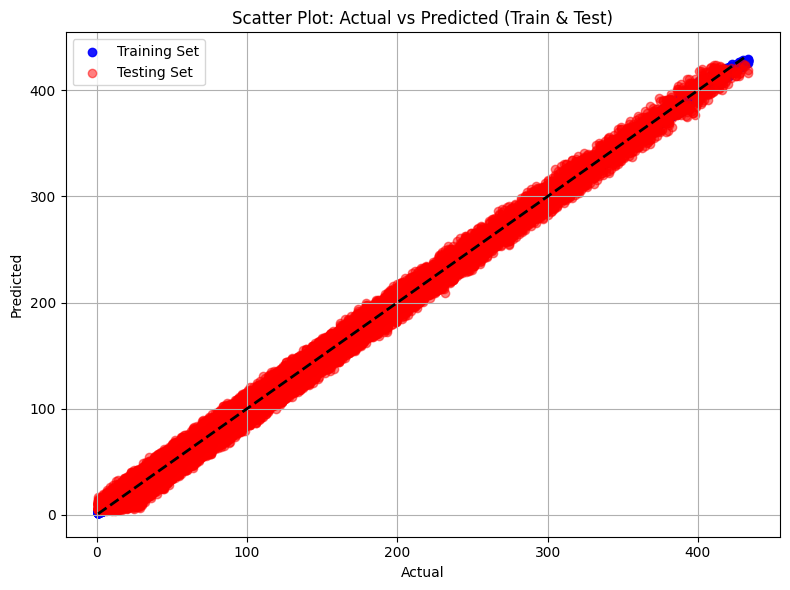

In [66]:
# plot data y aktual vs y hasil prediksi

# Scatter plot
plt.figure(figsize=(8, 6))

# Titik training
plt.scatter(y_train_actual, y_train_pred, color='blue', alpha=0.9, label='Training Set')

# Titik testing
plt.scatter(y_test_actual, y_test_pred, color='red', alpha=0.5, label='Testing Set')

# Garis referensi: y = x
min_val = min(y_test_actual.min(), y_train_actual.min())
max_val = max(y_test_actual.max(), y_train_actual.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Label
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot: Actual vs Predicted (Train & Test)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


## Hyperparameter Tuning

In [19]:

# Parameter grid
param_dist = {
    'n_estimators': randint(100, 501),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}

# Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Inisialisasi model
rf_tuned = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_tuned, 
    param_distributions=param_dist,
    n_iter=30, 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    scoring='neg_mean_absolute_error', 
    random_state=42
)

# Jalankan
random_search.fit(X_train, y_train_log)

# Ambil model terbaik
best_rf = random_search.best_estimator_

# Prediksi dalam bentuk log
y_pred_train_log = best_rf.predict(X_train)
y_pred_test_log = best_rf.predict(X_test) 

# Kembalikan ke skala asli
y_train_pred = np.expm1(y_pred_train_log)
y_test_pred = np.expm1(y_pred_test_log)
y_train_actual = np.expm1(y_train_log)
y_test_actual = np.expm1(y_test_log)

# fungsi mencari mape
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Train
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

# Test
mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

print("Best Params:", random_search.best_params_)
print("Best Score:", random_search.best_score_)
print(f"Train MAE: {mae_train:.2f}")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train MAPE: {mape_train:.2f}%")
print("-" * 40)
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAPE: {mape_test:.2f}%")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 301}
Best Score: -0.13017179001524803
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.48%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%


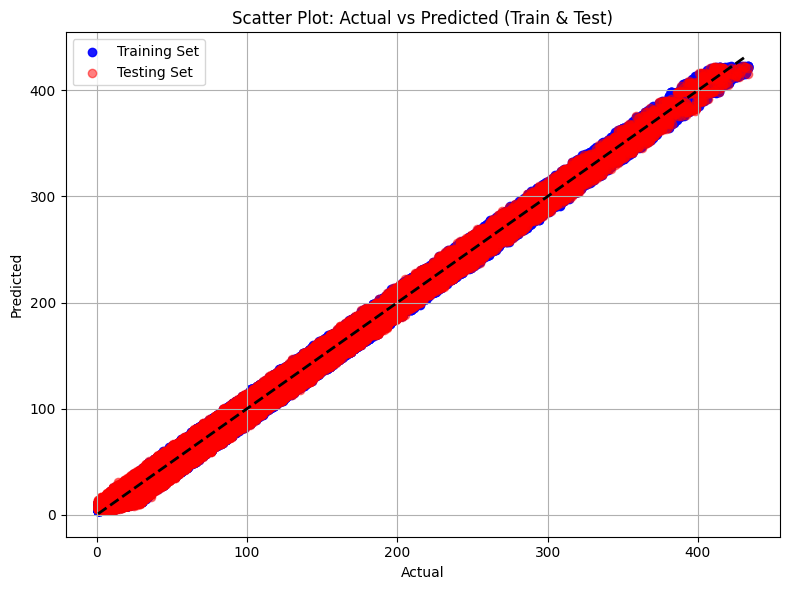

In [55]:
# plot data y aktual vs y hasil prediksi

# Scatter plot
plt.figure(figsize=(8, 6))

# Titik training
plt.scatter(y_train_actual, y_train_pred, color='blue', alpha=0.9, label='Training Set')

# Titik testing
plt.scatter(y_test_actual, y_test_pred, color='red', alpha=0.5, label='Testing Set')

# Garis referensi: y = x
min_val = min(y_test_actual.min(), y_train_actual.min())
max_val = max(y_test_actual.max(), y_train_actual.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

# Label
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Scatter Plot: Actual vs Predicted (Train & Test)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [19]:

# 1. Parameter grid (lebih sempit, karena GridSearch akan mencoba semua kombinasi)
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 2. Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 3. Inisialisasi model
rf_grid = RandomForestRegressor(random_state=42)

# 4. GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

# 5. Latih model
grid_search.fit(X_train, y_train_log)

# 6. Model terbaik
best_rf_grid = grid_search.best_estimator_

# 7. Prediksi (log) → skala asli
y_pred_train_log = best_rf_grid.predict(X_train)
y_pred_test_log = best_rf_grid.predict(X_test)

y_train_pred = np.expm1(y_pred_train_log)
y_test_pred = np.expm1(y_pred_test_log)
y_train_actual = np.expm1(y_train_log)
y_test_actual = np.expm1(y_test_log)

# 8. Fungsi MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# 9. Evaluasi
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)
r2_train = r2_score(y_train_actual, y_train_pred)

mae_test = mean_absolute_error(y_test_actual, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)
r2_test = r2_score(y_test_actual, y_test_pred)

# 10. Output
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print(f"Train MAE: {mae_train:.2f}")
print(f"Train RMSE: {rmse_train:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Train MAPE: {mape_train:.2f}%")
print("-" * 40)
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R2: {r2_test:.2f}")
print(f"Test MAPE: {mape_test:.2f}%")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best Score: -0.1301328737013983
Train MAE: 6.79
Train RMSE: 7.96
Train R2: 0.99
Train MAPE: 15.44%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test R2: 0.99
Test MAPE: 17.79%


## Testing/Validasi Hasil Hyperparameter Tuning

In [56]:
# testing pada kombinasi hyperparameter dengan basis dasar parameter hasil randomized search


# Kombinasi hyperparameter pada n_estimators
param_list_n_esti = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 400, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 500, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}
]

# Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Mencoba berbagai kombinasi
for param in param_list_n_esti:
    print(f"Training with params: {param}")
    
    # build & fit model
    rf_test1 = RandomForestRegressor(random_state=42, **param)
    rf_test1.fit(X_train, y_train_log)

    # Prediksi dalam bentuk log
    y_pred_train_log = rf_test1.predict(X_train)
    y_pred_test_log = rf_test1.predict(X_test) 

    # Kembalikan ke skala asli
    y_train_pred = np.expm1(y_pred_train_log)
    y_test_pred = np.expm1(y_pred_test_log)
    y_train_actual = np.expm1(y_train_log)
    y_test_actual = np.expm1(y_test_log)
    
    # fungsi mencari mape
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    # Train
    mae_train = mean_absolute_error(y_train_actual, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

    # Test
    mae_test = mean_absolute_error(y_test_actual, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

    # Print
    print(f"Train MAE: {mae_train:.2f}")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Train MAPE: {mape_train:.2f}%")
    print("-" * 40)
    print(f"Test MAE: {mae_test:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}")
    print(f"Test MAPE: {mape_test:.2f}%")
    print("-" * 100)

Training with params: {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 6.80
Train RMSE: 7.97
Train MAPE: 15.47%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.80%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.47%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.80%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.48%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
------------------------------------------------

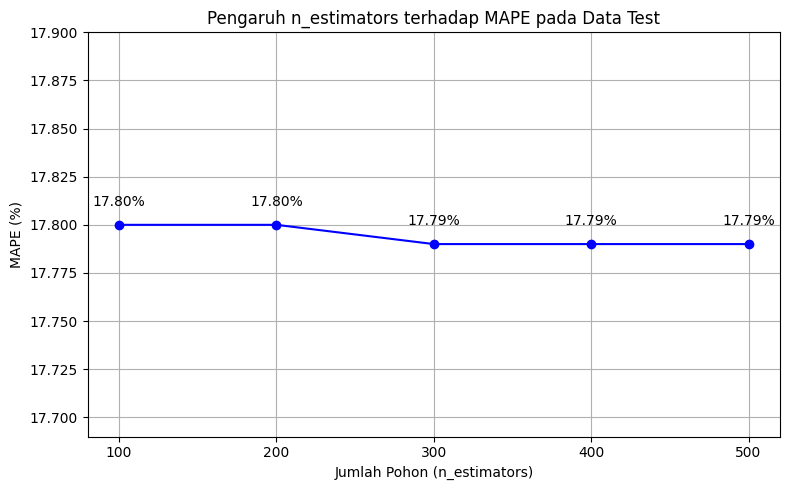

In [28]:
# line chart kombinasi n_estimators dengan basis best param

# Daftar nilai n_estimators yang diuji
n_estimators_list = [100, 200, 300, 400, 500]

# Hasil MAPE pada data test set dari masing-masing model
mape_test_list = [17.80, 17.80, 17.79, 17.79, 17.79]

# Membuat plot
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, mape_test_list, marker='o', linestyle='-', color='blue')
plt.title("Pengaruh n_estimators terhadap MAPE pada Data Test")
plt.xlabel("Jumlah Pohon (n_estimators)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.xticks(n_estimators_list)
plt.ylim(min(mape_test_list) - 0.1, max(mape_test_list) + 0.1)

# Tampilkan nilai di atas titik
for x, y in zip(n_estimators_list, mape_test_list):
    plt.text(x, y + 0.01, f"{y:.2f}%", ha='center')

plt.tight_layout()
plt.show()


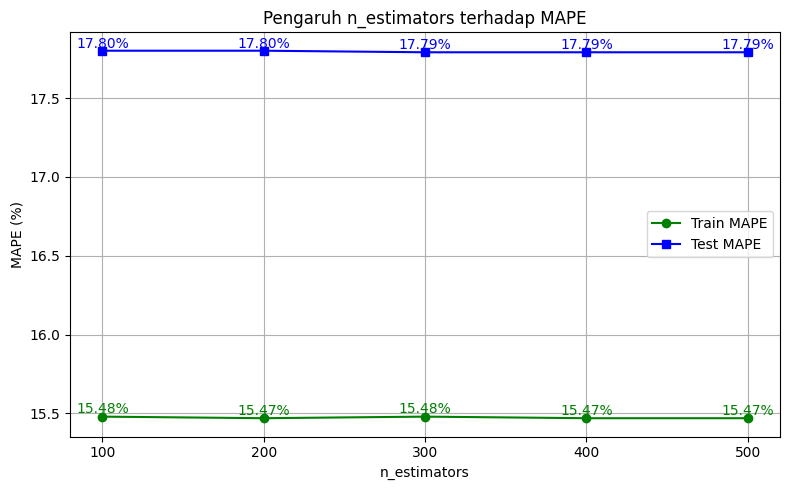

In [29]:


# Daftar nilai n_estimators dan MAPE
n_estimators_list = [100, 200, 300, 400, 500]
mape_train_list = [15.48, 15.47, 15.48, 15.47, 15.47]
mape_test_list  = [17.80, 17.80, 17.79, 17.79, 17.79]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, mape_train_list, marker='o', label='Train MAPE', color='green')
plt.plot(n_estimators_list, mape_test_list, marker='s', label='Test MAPE', color='blue')

# Tambahkan label angka di atas titik
for x, y in zip(n_estimators_list, mape_train_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='green')
for x, y in zip(n_estimators_list, mape_test_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='blue')

# Tambahan lainnya
plt.title("Pengaruh n_estimators terhadap MAPE")
plt.xlabel("n_estimators")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.xticks(n_estimators_list)
plt.tight_layout()
plt.show()


In [26]:
# Kombinasi hyperparameter pada max_depth

param_list_max_depth = [
    {'n_estimators': 301, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 3}
]

# Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Mencoba berbagai kombinasi
for param in param_list_max_depth:
    print(f"Training with params: {param}")
    
    # build & fit model
    rf_test2 = RandomForestRegressor(random_state=42, **param)
    rf_test2.fit(X_train, y_train_log)

    # Prediksi dalam bentuk log
    y_pred_train_log = rf_test2.predict(X_train)
    y_pred_test_log = rf_test2.predict(X_test) 

    # Kembalikan ke skala asli
    y_train_pred = np.expm1(y_pred_train_log)
    y_test_pred = np.expm1(y_pred_test_log)
    y_train_actual = np.expm1(y_train_log)
    y_test_actual = np.expm1(y_test_log)
    
    # fungsi mencari mape
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    # Train
    mae_train = mean_absolute_error(y_train_actual, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

    # Test
    mae_test = mean_absolute_error(y_test_actual, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

    # Print
    print(f"Train MAE: {mae_train:.2f}")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Train MAPE: {mape_train:.2f}%")
    print("-" * 40)
    print(f"Test MAE: {mae_test:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}")
    print(f"Test MAPE: {mape_test:.2f}%")
    print("-" * 100)

Training with params: {'n_estimators': 301, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 3.30
Train RMSE: 3.96
Train MAPE: 7.07%
----------------------------------------
Test MAE: 7.40
Test RMSE: 8.71
Test MAPE: 17.89%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.48%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 301, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 3.74
Train RMSE: 4.46
Train MAPE: 8.05%
----------------------------------------
Test MAE: 7.38
Test RMSE: 8.68
Test MAPE: 17.90%
------------------------------------------------

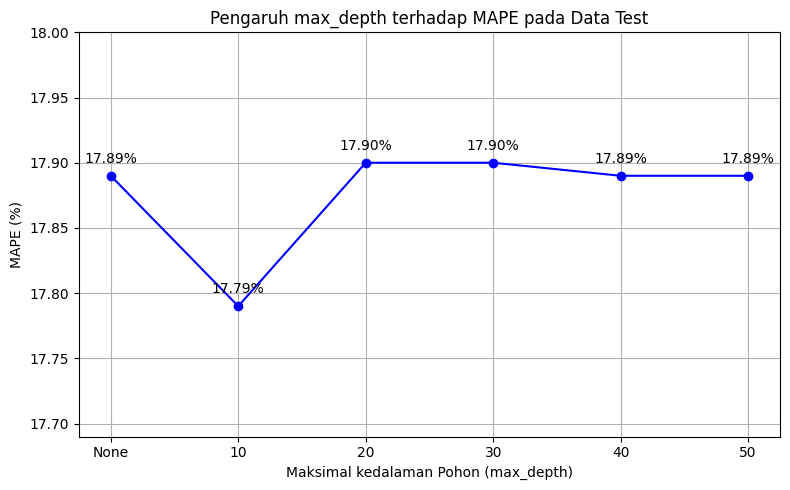

In [ ]:
# line chart kombinasi max_depth dengan basis best param

# Daftar nilai max_depth dan MAPE
max_depth_raw = [None, 10, 20, 30, 40, 50]
max_depth_str = ['None' if v is None else str(v) for v in max_depth_raw]
mape_test_list = [17.89, 17.79, 17.90, 17.90, 17.89, 17.89]

# Gunakan indeks sebagai x-axis numerik
x_pos = list(range(len(max_depth_raw)))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_pos, mape_test_list, marker='o', linestyle='-', color='blue')
plt.title("Pengaruh max_depth terhadap MAPE pada Data Test")
plt.xlabel("Maksimal kedalaman Pohon (max_depth)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.xticks(ticks=x_pos, labels=max_depth_str)
plt.ylim(min(mape_test_list) - 0.1, max(mape_test_list) + 0.1)

# Tampilkan nilai MAPE di atas titik
for x, y in zip(x_pos, mape_test_list):
    plt.text(x, y + 0.01, f"{y:.2f}%", ha='center')

plt.tight_layout()
plt.show()

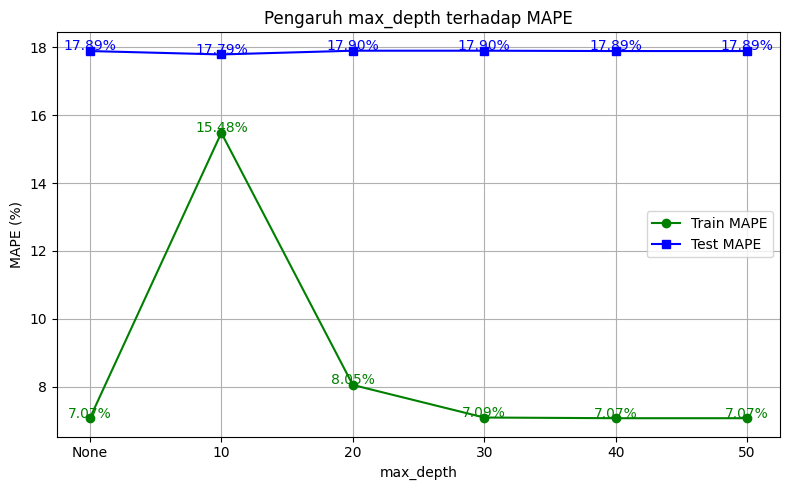

In [27]:


# Daftar nilai max_depth (ganti None dengan string agar tidak error)
max_depth_raw = [None, 10, 20, 30, 40, 50]
max_depth_str = ['None' if v is None else str(v) for v in max_depth_raw]
mape_train_list = [7.07, 15.48, 8.05, 7.09, 7.07, 7.07]
mape_test_list  = [17.89, 17.79, 17.90, 17.90, 17.89, 17.89]

# Gunakan indeks sebagai x-axis numerik
x_pos = list(range(len(max_depth_raw)))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_pos, mape_train_list, marker='o', label='Train MAPE', color='green')
plt.plot(x_pos, mape_test_list, marker='s', label='Test MAPE', color='blue')

# Tambahkan nilai MAPE di atas titik
for x, y in zip(x_pos, mape_train_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='green')
for x, y in zip(x_pos, mape_test_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='blue')

# Finalisasi tampilan
plt.title("Pengaruh max_depth terhadap MAPE")
plt.xlabel("max_depth")
plt.ylabel("MAPE (%)")
plt.xticks(ticks=x_pos, labels=max_depth_str)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# Kombinasi hyperparameter pada mim_samples_leaf

param_list_min_smplf = [
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 3}, 
]

# Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Mencoba berbagai kombinasi
for param in param_list_min_smplf:
    print(f"Training with params: {param}")
    
    # build & fit model
    rf_test3 = RandomForestRegressor(random_state=42, **param)
    rf_test3.fit(X_train, y_train_log)

    # Prediksi dalam bentuk log
    y_pred_train_log = rf_test3.predict(X_train)
    y_pred_test_log = rf_test3.predict(X_test) 

    # Kembalikan ke skala asli
    y_train_pred = np.expm1(y_pred_train_log)
    y_test_pred = np.expm1(y_pred_test_log)
    y_train_actual = np.expm1(y_train_log)
    y_test_actual = np.expm1(y_test_log)
    
    # fungsi mencari mape
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    # Train
    mae_train = mean_absolute_error(y_train_actual, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

    # Test
    mae_test = mean_absolute_error(y_test_actual, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

    # Print
    print(f"Train MAE: {mae_train:.2f}")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Train MAPE: {mape_train:.2f}%")
    print("-" * 40)
    print(f"Test MAE: {mae_test:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}")
    print(f"Test MAPE: {mape_test:.2f}%")
    print("-" * 100)

Training with params: {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.45%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.48%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 3}
Train MAE: 6.80
Train RMSE: 7.97
Train MAPE: 15.53%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
------------------------------------------------

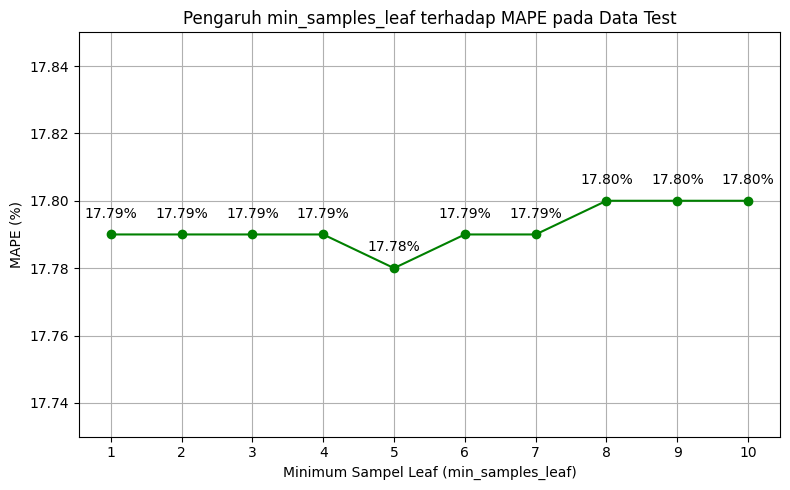

In [62]:
# line chart kombinasi min_samples_leaf dengan basis best param

# Data hasil eksperimen
min_samples_leaf_list = list(range(1, 11))
mape_test_list = [17.79, 17.79, 17.79, 17.79, 17.78, 17.79, 17.79, 17.80, 17.80, 17.80]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(min_samples_leaf_list, mape_test_list, marker='o', linestyle='-', color='green')
plt.title("Pengaruh min_samples_leaf terhadap MAPE pada Data Test")
plt.xlabel("Minimum Sampel Leaf (min_samples_leaf)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.xticks(min_samples_leaf_list)
plt.ylim(min(mape_test_list) - 0.05, max(mape_test_list) + 0.05)

# Tambahkan label pada titik
for x, y in zip(min_samples_leaf_list, mape_test_list):
    plt.text(x, y + 0.005, f"{y:.2f}%", ha='center')

plt.tight_layout()
plt.show()


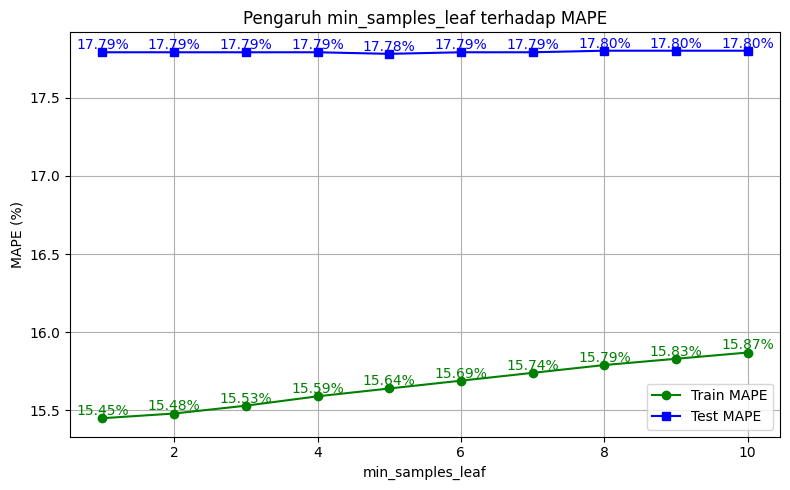

In [38]:

min_samples_leaf_list = list(range(1, 11))
mape_train_list = [15.45, 15.48, 15.53, 15.59, 15.64, 15.69, 15.74, 15.79, 15.83, 15.87]
mape_test_list = [17.79, 17.79, 17.79, 17.79, 17.78, 17.79, 17.79, 17.80, 17.80, 17.80]

plt.figure(figsize=(8, 5))
plt.plot(min_samples_leaf_list, mape_train_list, marker='o', label='Train MAPE', color='green')
plt.plot(min_samples_leaf_list, mape_test_list, marker='s', label='Test MAPE', color='blue')

# Tampilkan nilai di atas titik
for x, y in zip(min_samples_leaf_list, mape_train_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='green')
for x, y in zip(min_samples_leaf_list, mape_test_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='blue')

plt.title("Pengaruh min_samples_leaf terhadap MAPE")
plt.xlabel("min_samples_leaf")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
# Kombinasi hyperparameter pada mim_samples_split

param_list_min_smplt = [
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 6}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 7}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}, 
    {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}, 
]

# Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Mencoba berbagai kombinasi
for param in param_list_min_smplt:
    print(f"Training with params: {param}")
    
    # build & fit model
    rf_test4 = RandomForestRegressor(random_state=42, **param)
    rf_test4.fit(X_train, y_train_log)

    # Prediksi dalam bentuk log
    y_pred_train_log = rf_test4.predict(X_train)
    y_pred_test_log = rf_test4.predict(X_test) 

    # Kembalikan ke skala asli
    y_train_pred = np.expm1(y_pred_train_log)
    y_test_pred = np.expm1(y_pred_test_log)
    y_train_actual = np.expm1(y_train_log)
    y_test_actual = np.expm1(y_test_log)
    
    # fungsi mencari mape
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    # Train
    mae_train = mean_absolute_error(y_train_actual, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
    mape_train = mean_absolute_percentage_error(y_train_actual, y_train_pred)

    # Test
    mae_test = mean_absolute_error(y_test_actual, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_actual, y_test_pred)

    # Print
    print(f"Train MAE: {mae_train:.2f}")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Train MAPE: {mape_train:.2f}%")
    print("-" * 40)
    print(f"Test MAE: {mae_test:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}")
    print(f"Test MAPE: {mape_test:.2f}%")
    print("-" * 100)

Training with params: {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.48%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.48%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
----------------------------------------------------------------------------------------------------
Training with params: {'n_estimators': 301, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 4}
Train MAE: 6.79
Train RMSE: 7.97
Train MAPE: 15.48%
----------------------------------------
Test MAE: 7.27
Test RMSE: 8.49
Test MAPE: 17.79%
------------------------------------------------

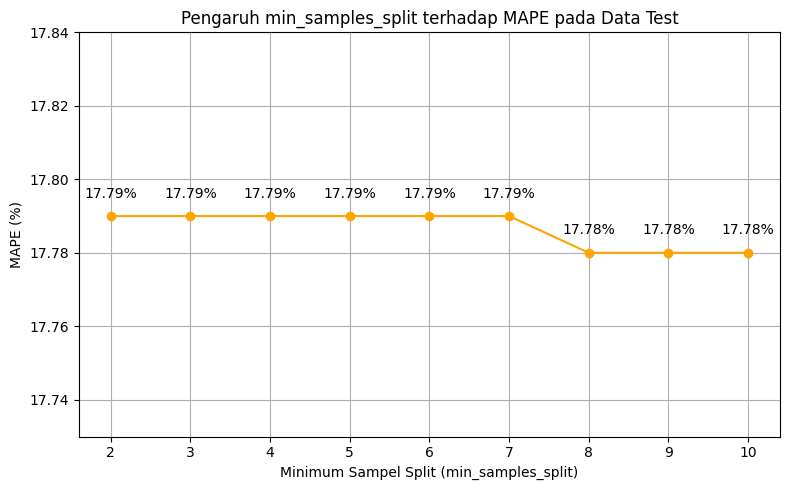

In [64]:
# line chart kombinasi min_samples_split dengan basis best param

# Data
min_samples_split_list = list(range(2, 11))
mape_test_list = [17.79, 17.79, 17.79, 17.79, 17.79, 17.79, 17.78, 17.78, 17.78]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(min_samples_split_list, mape_test_list, marker='o', linestyle='-', color='orange')
plt.title("Pengaruh min_samples_split terhadap MAPE pada Data Test")
plt.xlabel("Minimum Sampel Split (min_samples_split)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.xticks(min_samples_split_list)
plt.ylim(min(mape_test_list) - 0.05, max(mape_test_list) + 0.05)

# Label nilai di atas titik
for x, y in zip(min_samples_split_list, mape_test_list):
    plt.text(x, y + 0.005, f"{y:.2f}%", ha='center')

plt.tight_layout()
plt.show()


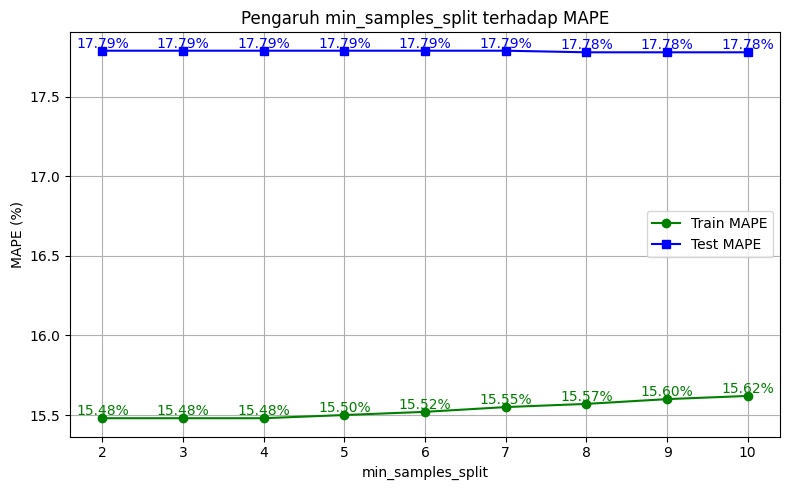

In [36]:
min_samples_split_list = list(range(2, 11))
mape_train_list = [15.48, 15.48, 15.48, 15.50, 15.52, 15.55, 15.57, 15.60, 15.62]
mape_test_list  = [17.79] * 6 + [17.78, 17.78, 17.78]

plt.figure(figsize=(8, 5))
plt.plot(min_samples_split_list, mape_train_list, marker='o', label='Train MAPE', color='green')
plt.plot(min_samples_split_list, mape_test_list, marker='s', label='Test MAPE', color='blue')

# Tampilkan nilai di atas titik
for x, y in zip(min_samples_split_list, mape_train_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='green')
for x, y in zip(min_samples_split_list, mape_test_list):
    plt.text(x, y + 0.02, f"{y:.2f}%", ha='center', color='blue')

plt.title("Pengaruh min_samples_split terhadap MAPE")
plt.xlabel("min_samples_split")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Learning Curve Terhadap Best Param

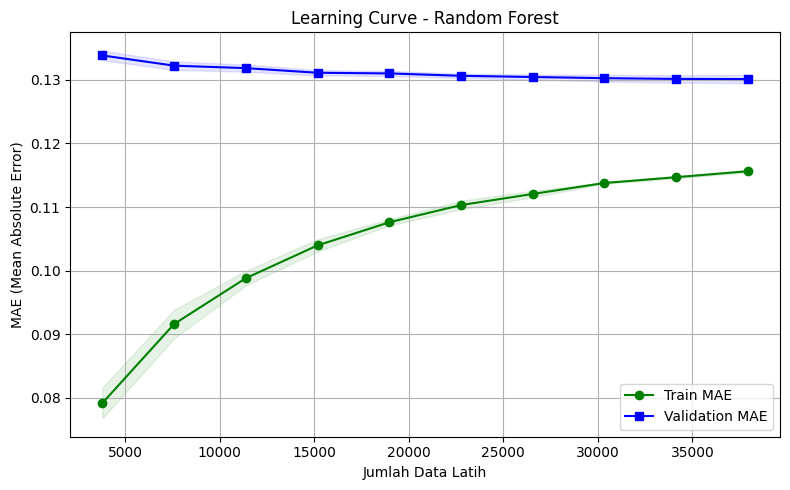

In [51]:
# Gunakan log-transformed target (jika memang itu yang digunakan dalam pelatihan)
y_train_log = np.log1p(y_train)

# Inisialisasi model
rf_model_lc = RandomForestRegressor(
    random_state=42,
    n_estimators=301,
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=3
)

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=rf_model_lc,
    X=X_train,
    y=y_train_log,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Hitung rata-rata dan standar deviasi
train_mae_mean = -np.mean(train_scores, axis=1)
val_mae_mean = -np.mean(val_scores, axis=1)

train_mae_std = np.std(train_scores, axis=1)
val_mae_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mae_mean, 'o-', label='Train MAE', color='green')
plt.plot(train_sizes, val_mae_mean, 's-', label='Validation MAE', color='blue')
plt.fill_between(train_sizes, train_mae_mean - train_mae_std, train_mae_mean + train_mae_std, alpha=0.1, color='green')
plt.fill_between(train_sizes, val_mae_mean - val_mae_std, val_mae_mean + val_mae_std, alpha=0.1, color='blue')

plt.title("Learning Curve - Random Forest")
plt.xlabel("Jumlah Data Latih")
plt.ylabel("MAE (Mean Absolute Error)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Save Final Model

In [20]:
import joblib

# Simpan model hasil tuning
joblib.dump(best_rf, 'final_rf_model.pkl')

# Simpan label encoder untuk 'Seasonality'
joblib.dump(label_encoder, 'seasonality_encoder.pkl')

['seasonality_encoder.pkl']